# Решение кита 

# !!!

> При симуляциях используется многопоточность.
    * Ryzen 5 3600 - 17 симуляций(по 100 повторений в каждом) заняли 7м 15сек  
    * MacBook Air 11 дюймов - 1.5 часа xddd


# !!!

__Импорты__

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

from multiprocessing import Process, Queue

warnings.filterwarnings('ignore')

__Создадим 2 класса__ <br/>

**TrainStation** - шаблон станции, имеет следующие атрибуты 
* *station_code* - код данной станции
* *station_type* - тип станции  ( $жилая = 150$, $промышленная = 50$)
* *people_amount* - количество людей на платформе станции
* *time* - текущее время на станции 
* *states* - количество людей на станции в каждый момент времени

In [2]:
class TrainStation:

    def __init__(self, station_code, station_type):
        self.station_code = station_code  # Кодируем в цифры, 0 - депо etc.
        self.station_type = station_type  # 50 - промышленные, 150 - жилые
        self.people_amount = 0  # Количество людей на платформе станции
        self.time = 1  # Текущее время на станции 
        self.states = np.zeros(541)

    """
    Спавнит новых людей на станцию
    
    y: Лямбда в распределении Пуассона
    z: Число людей, которое прибыло на платформу в течение минуты
    """
    
    def new_people(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-0.03 * x))

        def f(x):
            return sigmoid(x) * (1 - sigmoid(x))

        y = self.station_type * f(self.time - (self.station_code + 3) * 30)
        z = np.random.poisson(lam=y)
        self.time += 1
        self.people_amount += z
        self.states[self.time] = self.people_amount

    def update_time(self):
        self.new_people()


**Train** - шаблон поезда
* *departure_time* - время прибытия на первую станцию
* *people_amount* - количество людей на платформе станции
* *full* - вместимость поезда
* *current_station* - станция на которой находится поезд
* *available* - показывает, заполнен ли поезд
* *empty* - Флаг для стратегии "Пустой поезд"

In [3]:
class Train:
    
    """
    departure_time - время прибытия на первую станцию
    people_amount - количество людей на платформе станции
    full - вместимость поезда
    current_station - станция на которой находится поезд
    available - показывает, заполнен ли поезд
    empty - Флаг для стратегии "Пустой поезд"
    """
    
    
    def __init__(self, departure_time):
        self.departure_time = departure_time  # Время прибытия на первую станцию
        self.people_amount = 0  # Количество людей в поезде
        self.full = 0  # Вместимость поезда
        self.current_station = 0  # 0 - Жулебино
        self.available = True  # Показывает, заполнен ли поезд
        self.next_station = 0
        self.empty = False  # Флаг для стратегии "Пустой поезд"

    """
    Метод загружает людей в поезд
    """
    
    def load_people(self, people_count):
        people_taken = 0
        for person in range(people_count):
            k = round(0.2 + self.current_station * 0.6, 1)
            prob = 1 - self.full**k
            if np.random.choice([False, True], 1, p=[1 - prob, prob]):
                people_taken += 1
                self.full = (self.people_amount + people_taken) / 500
                if self.full == 1:
                    self.available = False
                    break

        self.people_amount += people_taken
        self.next_station = self.current_station + 1
        return people_taken

    def update_station(self):
        self.current_station = self.next_station

## Один день в метро

In [15]:
def update_trains(trains):
    new_trains = []
    for train in trains:
        if train.available and train.current_station != 7:
            new_trains.append(train)
    return new_trains

def subway_hell(start_empty, target_station=4):
    # Создаём 8 станций и добавляем заглушку под поезда

    station_names = range(8)
    station_types = [150, 150, 150, 50, 150, 50, 50, 150]
    stations = [
        TrainStation(station_code=code, station_type=station_type)
        for code, station_type in zip(station_names, station_types)
    ]
    trains = []

    for minute in range(1, 540):
        if minute % 5 == 0:

            train = update_trains(trains)
            if minute != start_empty:
                # Добавляем обычный поезд
                trains.append(Train(departure_time=minute))
            else:
                # Добавляем на заданной минуте пустой поезд
                empty_train = Train(departure_time=minute)
                empty_train.empty = True
                trains.append(empty_train)
                start_empty += 25

            # Загрузка людей в поезда
            for station in stations:
                for train in trains:
                    if train.current_station == station.station_code and train.available is True:
                        if train.empty is False:
                            people = train.load_people(station.people_amount)
                            station.people_amount -= people
                        elif train.current_station < target_station - 1:
                            train.next_station = train.current_station + 1
                        else:
                            train.load_people(station.people_amount)
                            train.empty = False

        for train in trains:
            if train.available:
                train.update_station()

        for station in stations:
            station.update_time()

    times = []
    
    # Сохраняем количество людей на каждой станции в каждый момент времени
    for station in stations:
        if station.station_code != 7:
            times.append(station.states)

    all_times = np.zeros(541)
    for time in times:
        all_times += time
    times.append(all_times)

    return times

## Симуляция метро

Данная функция запускает метро **n_test** раз.\
Через **minutes** можно указать с какой минуты первый пустой поезд приедет в Жулебино.

In [5]:
def simulation_a(n_test, minutes):
    results = []
    for i in range(n_test):
        test = subway_hell(minutes)
        frame = pd.DataFrame(test).transpose()
        results.append(frame)
    return results

### Ответ на пункт [а]
__а)__  На какой станции скапливается максимальное число людей? Во сколько это происходит? Постройте картинки с зависимостью числа людей на платформе от времени для каждой станции. Есть ли на этих картинках что-то странное? Как бы вы это объяснили? 


Нарисуем график одной симуляции 

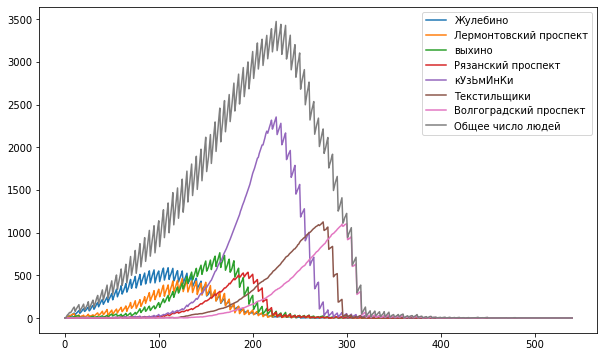

In [6]:
one_sample = subway_hell(False)
station_name = ['Жулебино', 'Лермонтовский проспект', 'выхино', 'Рязанский проспект',\
                'кУзЬмИнКи', 'Текстильщики', 'Волгоградский проспект', 'Общее число людей']
one_sample_df = pd.DataFrame(one_sample).transpose()
one_sample_df.columns = station_name
one_sample_df.plot();

__Картинки по станциям__

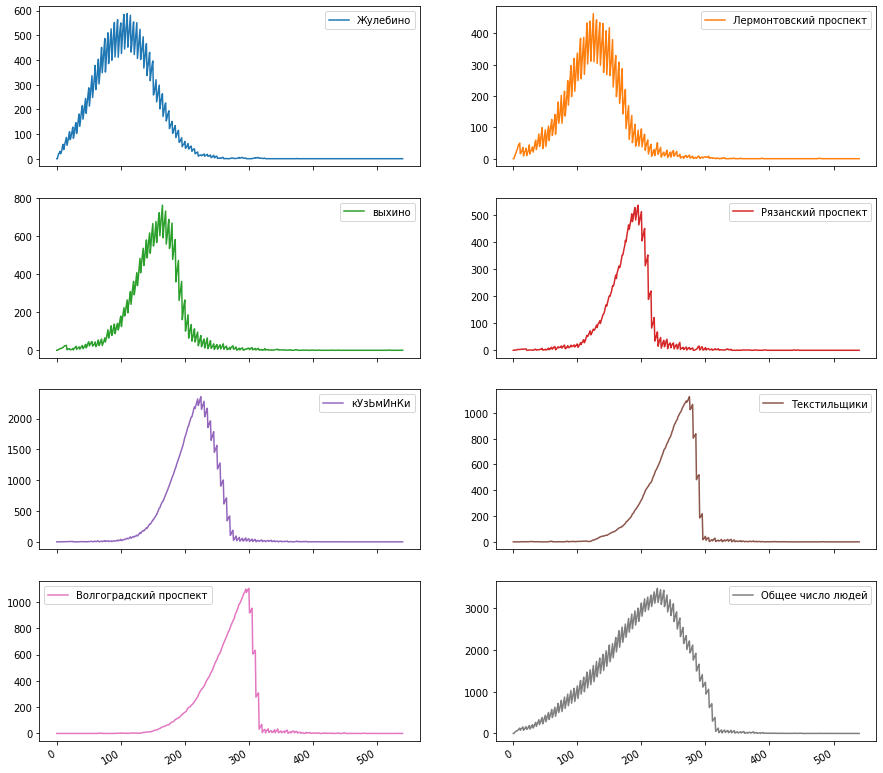

In [7]:
one_sample_df.plot(subplots=True, layout=(4, 2), figsize=(15, 15));

> Уже очевидно, что больше всего народу на Кузьминках \
Из странностей(не вижу ничего странного):
* Ребристость (это из-за поездов, которые забирают людей каждые 5 минут)
* Начиная с Рязанского проспекта поезда уже не справляются, \
поэтому линии на графиках становятся гладкие

Сделаем 100 симуляций, чтобы получить среднее значени максимального числа людей по станциям и время пиков

In [8]:
n_observ = 100
result_time = np.zeros(7)
result_minute = np.zeros(7)
sims = simulation_a(n_observ, False)

for simulation in sims:
    result_time += simulation.max().to_list()[:-1]
    result_minute += simulation.idxmax().to_list()[:-1]
max_people = (result_time/n_observ).round() # Округляем, чтобы не было половины человека
max_minute = result_minute/n_observ

In [9]:
max_people
max_minute
peaks_df = pd.DataFrame([max_minute, max_people], columns=station_name[:-1], index=['Минуты', 'Люди'])
peaks_df

,Жулебино,Лермонтовский проспект,выхино,Рязанский проспект,кУзЬмИнКи,Текстильщики,Волгоградский проспект
Минуты,108.35,131.45,164.55,194.0,225.2,276.1,299.95
Люди,606.00,478.00,820.00,535.0,2360.0,1155.0,1128.00


__Да, график не соврал, на Кузьминках на  ~ 226 минуте скапливается максимальное число людей ~ 2379.__

### Ответ на пункт [б]

__б)__  Администрация метро хочет противодействовать проблемам со скапливанием людей. Для этого она придумывает стратегию "пустой поезд". Каждый пятый поезд, приезжающий в Кузьминки будет пустым. Он будет проезжать мимо всех станций и забирать людей из Кузьминок. Выберите оптимальное время запуска пустого поезда, руководствуясь результатами из пункта а). Насколько сильно такая стратегия ухудшит состояние всех оставшихся станций? Правда ли, что Кузьминки вздохнут спокойно и разгрузятся? 


# !!
# Вот тут уже многопоток

In [10]:
Q = Queue()

def simulation_b(n_test, minutes, target_station=4):
    results = np.zeros(n_test)
    kuzminki = np.zeros(n_test)
    for i in range(n_test):
        test = subway_hell(minutes, target_station=target_station)
        results[i] = np.sum(test[6])
        kuzminki[i] = np.sum(test[target_station])
    result = np.mean(results)
    kuzminki_mean = np.mean(kuzminki)
    #print(f'Пустой поезд отправляется(c первой платформы) в {minutes} | Результат = {result}')
    Q.put((minutes, result, kuzminki_mean))

# !!

Делаем первоначальную разведку. Идем 10 минутками с 100-ой до 300-ой минуты, делая по 1000 симуляций. \
Результат показывает среднее число людей во всем метро. \
Там где $Результат =  False$ не использовалась стратегия "пустой поезд"

In [6]:
def mp_simulation(start, stop, step, reps=1000, target_station=4):
    
    n_minutes = list(range(start, stop, step))
    n_minutes.append(False)
    n_tests = np.repeat(reps, len(n_minutes))
    procs = []
    results = []
    
    for test, minute in zip(n_tests, n_minutes):
        proc = Process(target=simulation_b, args=(test, minute, target_station))
        procs.append(proc)
        proc.start()
    
    for proc in procs:
        results.append(Q.get())
        proc.join()
    while not Q.empty():
        Q.get()
        print(Q.empty())
    return results 

In [12]:
col_names = ['Время запуска', 'Среднее количество людей в метро', 'Среднее число людей в Кузьминках']
scout_df = pd.DataFrame(mp_simulation(100, 301, 10), columns=col_names).sort_values(by=['Время запуска'])
scout_df

In [13]:
scout_df

,Время запуска,Среднее количество людей в метро,Среднее число людей в Кузьминках
4,False,76192.058,177603.590
21,100,112892.310,264328.594
20,110,109768.435,254504.412
19,120,105674.573,241977.351
18,130,103212.897,233386.167
17,140,101562.600,230397.921
13,150,99006.502,228373.442
14,160,96163.439,226214.435
16,170,92396.876,218340.314
12,180,88815.534,209512.622


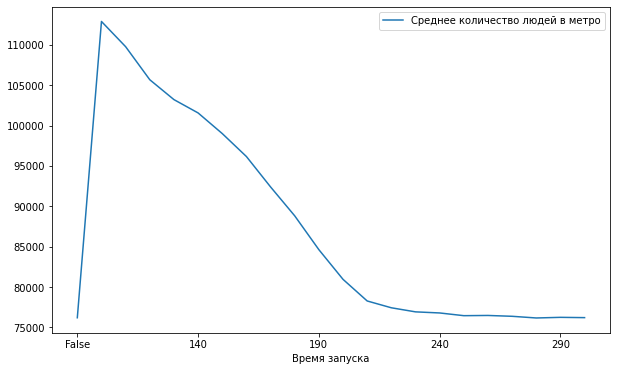

In [14]:
scout_df.plot(x=col_names[0], y=col_names[1]);

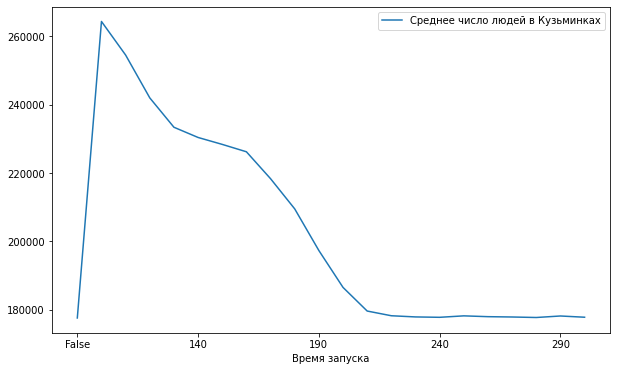

In [15]:
scout_df.plot(x=col_names[0], y=col_names[2]);

Заметим, что запуск первго поезда до ~230 минуты ухудшает ситуацию, это вызвано тем, что поезда заполняются еще до Кузьминок, поэтому с Кузьминок людей начинают забирать раз в 25 минут, что приводит к скоплению людей.

__Посмотрим на 5-и минутки с 230 до 295__

In [16]:
next_df = pd.DataFrame(mp_simulation(230, 300, 5), columns=col_names).sort_values(by=['Время запуска'])

In [17]:
next_df

,Время запуска,Среднее количество людей в метро,Среднее число людей в Кузьминках
12,False,76192.058,177603.590
5,230,76921.529,177908.871
10,235,76826.303,177515.192
3,240,76785.555,177798.710
11,245,76690.687,177725.348
13,250,76449.007,178222.098
2,255,76415.429,177895.029
14,260,76476.434,177984.876
1,265,76401.199,178016.924
4,270,76371.681,177890.019


In [18]:
np.corrcoef(next_df['Время запуска'][1:].to_list(), next_df['Среднее количество людей в метро'][1:].to_list())

array([[ 1.        , -0.88626077],
       [-0.88626077,  1.        ]])

In [19]:
np.corrcoef(next_df['Время запуска'][1:11].to_list(), next_df['Среднее количество людей в метро'][1:11].to_list())

array([[ 1.       , -0.9538048],
       [-0.9538048,  1.       ]])

Видно, что в целом лучше не становится, но посмотрим на графики.

In [20]:
def simulate_n_plot(delay):
    stations = ['Жулебино', 'Лермонтовский проспект', 'выхино', 'Рязанский проспект',\
                'кУзЬмИнКи', 'Текстильщики', 'Волгоградский проспект', 'Общее число людей']
    
    stations_strategy = ['Жулебино_страт', 'Лермонтовский проспект_страт', 'выхино_страт',\
                         'Рязанский проспект_страт','кУзЬмИнКи_страт', 'Текстильщики_страт', \
                         'Волгоградский проспект_страт', 'Общее число людей_страт']
    
    simulate = subway_hell(delay)
    no_strategy = subway_hell(False)
    
    no_strategy_df = pd.DataFrame(no_strategy).transpose()
    temp = pd.DataFrame(simulate).transpose()
    temp.columns = stations_strategy
    no_strategy_df.columns = stations
    
    ax = no_strategy_df.plot();
    temp.plot(ax=ax, figsize=(16,9));
    
    

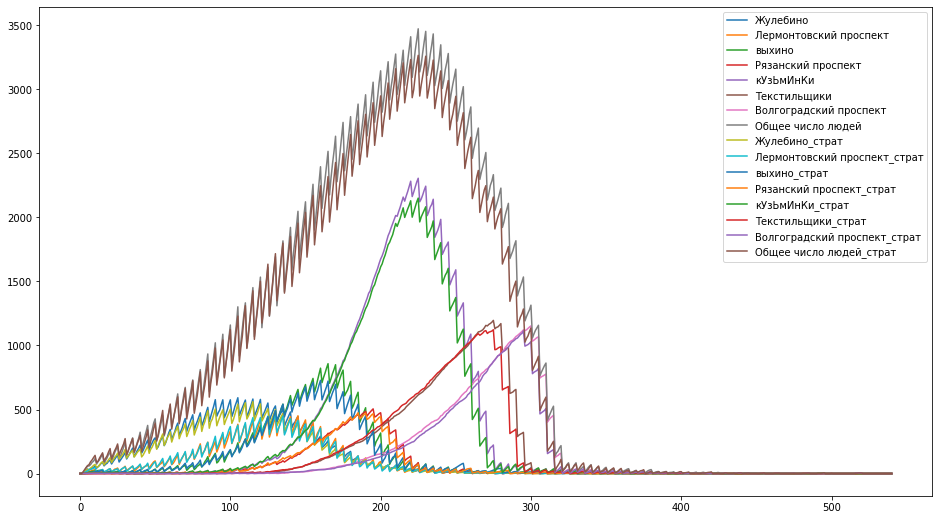

In [23]:
simulate_n_plot(240)

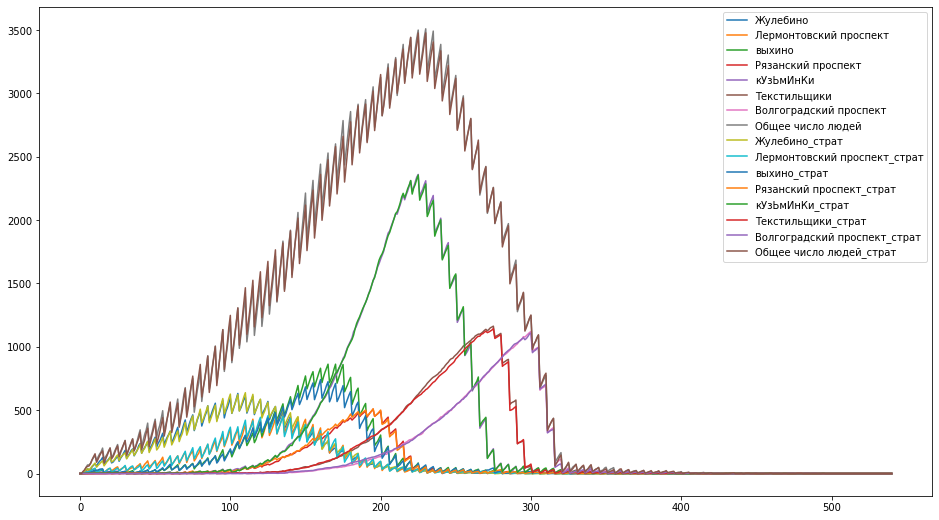

In [24]:
simulate_n_plot(260)

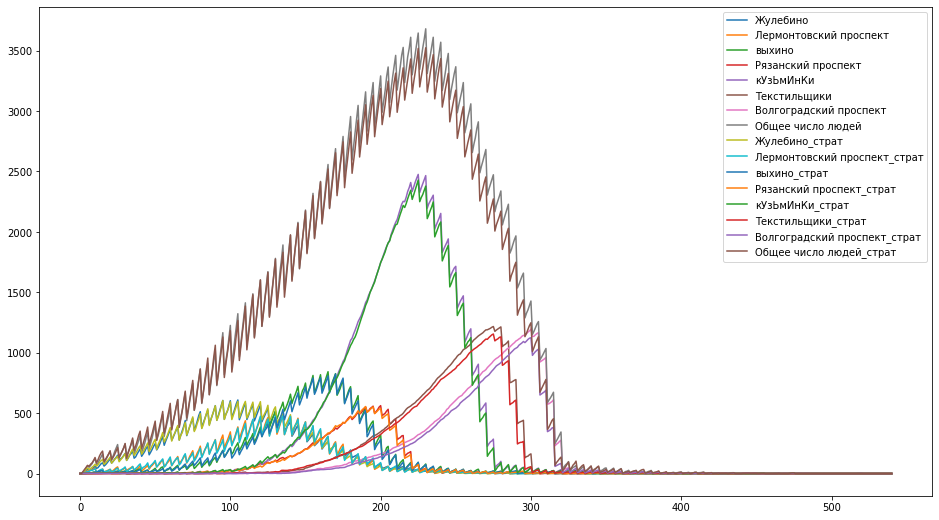

In [25]:
simulate_n_plot(275)

Результаты не впечатляют

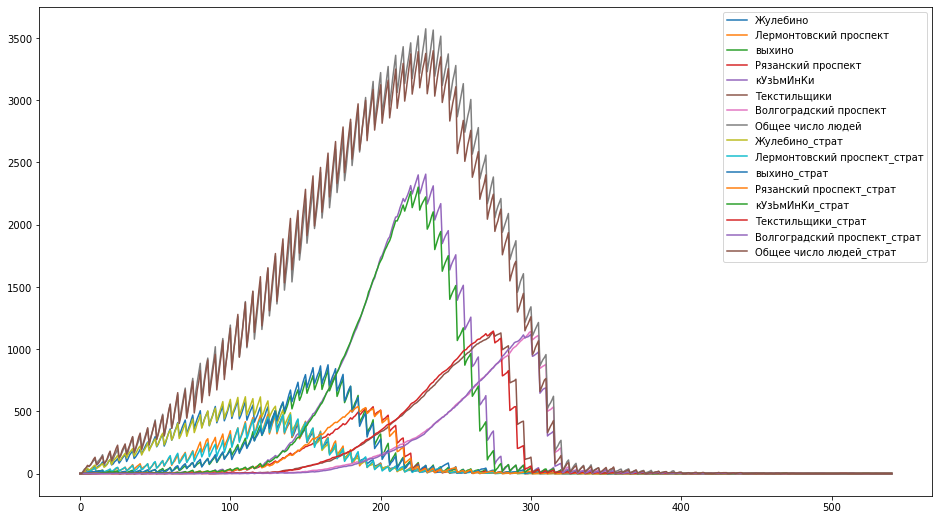

In [26]:
simulate_n_plot(230)

__Ответ:__ Данная стратегий не приносит желаемых результатов. Если отправлять к пику, то ситуация становится только хуже, так как поезда, которые не пустые, приезжают в Кузьминки уже забитые. 

### Ответ на пункт [в]
__в)__  Администрация метро решила, что будет считать проблемы, возникающие при загрузке как сумму всех людей на станциях. На какую станцию оптимальнее всего посылать каждый пятый поезд пустым, чтобы минимизировать эту величину? 

Попробуем посмотреть результаты для разных станций

In [8]:
col_names = ['Время запуска', 'Среднее количество людей в метро', 'Среднее число людей в Кузьминках']

In [10]:
col_names = ['Время запуска', 'Среднее количество людей в метро', 'Среднее число людей на Лермонтовском проспекте']
lermontovskiy_prospect = mp_simulation(50, 300, 5, reps=100, target_station=1)
lermontovskiy_df = pd.DataFrame(lermontovskiy_prospect, columns=col_names).sort_values(by=['Время запуска'])
lermontovskiy_df

,Время запуска,Среднее количество людей в метро,Среднее число людей в Кузьминках
5,False,76292.59,177635.26
48,50,90226.70,225021.55
49,55,90211.30,223982.26
50,60,91018.29,225561.23
46,65,90613.33,224789.68
44,70,90554.52,223251.66
43,75,89989.95,222639.03
47,80,89360.69,221173.82
42,85,89334.84,220347.04
41,90,88761.20,219472.52


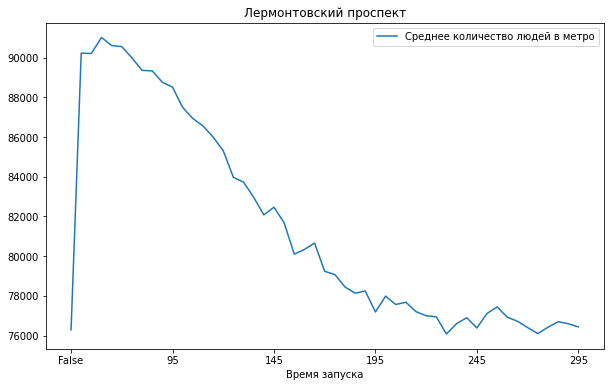

In [12]:
lermontovskiy_df.plot(x=col_names[0], y=col_names[1], title='Лермонтовский проспект')

In [7]:
col_names = ['Время запуска', 'Среднее количество людей в метро', 'Среднее число людей на Выхино']
vihino = mp_simulation(10, 240, 5, reps=100, target_station=2)
vihino_df = pd.DataFrame(vihino, columns=col_names).sort_values(by=['Время запуска'])
vihino_df

,Время запуска,Среднее количество людей в метро,Среднее число людей на Выхино
8,False,76307.88,58101.42
45,10,101249.92,93890.86
31,15,99706.55,92036.43
36,20,99480.97,92432.94
23,25,99919.83,92986.68
46,30,100368.83,93267.58
30,35,99996.98,93090.58
40,40,100887.31,93358.41
44,45,99975.29,92454.80
26,50,100759.99,92602.91


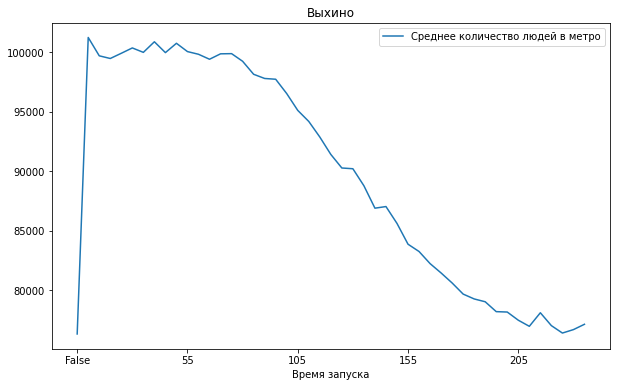

In [9]:
vihino_df.plot(x=col_names[0], y=col_names[1], title='Выхино')

In [11]:
col_names = ['Время запуска', 'Среднее количество людей в метро', 'Среднее число людей на Рязанском проспекте']
ryazan = mp_simulation(100, 301, 10, reps=100, target_station=2)
ryazan_df = pd.DataFrame(ryazan, columns=col_names).sort_values(by=['Время запуска'])
ryazan_df

,Время запуска,Среднее количество людей в метро,Среднее число людей на Рязанском проспекте
3,False,76307.88,58101.42
19,100,96530.00,83761.95
18,110,94185.65,79209.61
20,120,91410.66,73864.61
21,130,90207.32,70531.67
15,140,86889.82,65639.43
17,150,85607.73,63183.69
10,160,83244.70,60425.92
12,170,81439.16,59169.53
16,180,79662.51,58188.58


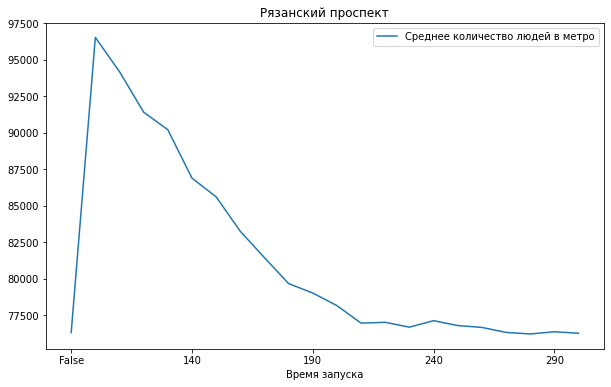

In [12]:
ryazan_df.plot(x=col_names[0], y=col_names[1], title='Рязанский проспект')

In [13]:
col_names = ['Время запуска', 'Среднее количество людей в метро', 'Среднее число людей на Текстильщиках']
tekst = mp_simulation(100, 301, 10, reps=100, target_station=2)
tekst_df = pd.DataFrame(tekst, columns=col_names).sort_values(by=['Время запуска'])
tekst_df

,Время запуска,Среднее количество людей в метро,Среднее число людей на Текстильщиках
12,False,76307.88,58101.42
20,100,96530.00,83761.95
19,110,94185.65,79209.61
21,120,91410.66,73864.61
18,130,90207.32,70531.67
17,140,86889.82,65639.43
10,150,85607.73,63183.69
16,160,83244.70,60425.92
14,170,81439.16,59169.53
9,180,79662.51,58188.58


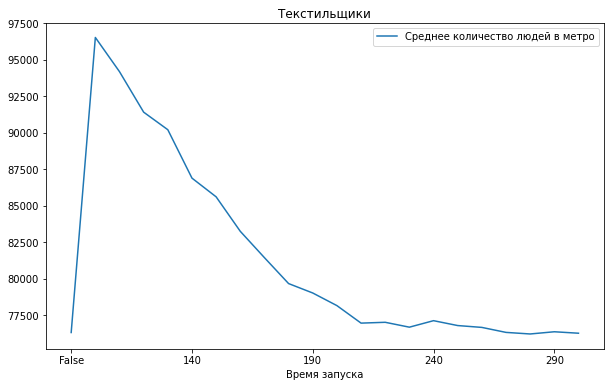

In [14]:
ryazan_df.plot(x=col_names[0], y=col_names[1], title='Текстильщики')